<span style="font-size:36px"><b>EDA & Data Wrangling</b></span>

Copyright 2019 Gunawan Lumban Gaol

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language overning permissions and limitations under the License.

# Import Packages

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
def convert_to_categorical(df, cat_limit=20):
    for col in df.columns:
        if (df[col].nunique() <= cat_limit):
            df[col] = df[col].astype('category')
            print("Column {} casted to categorical".format(col))

# Import Data

* application_{train|test}.csv
    * This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
    * Static data for all applications. One row represents one loan in our data sample.

* bureau.csv
    * All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
    * For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

* bureau_balance.csv
    * Monthly balances of previous credits in Credit Bureau.
    * This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.
    
* POS_CASH_balance.csv
    * Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
    * This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

* credit_card_balance.csv
    * Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
    * This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

* previous_application.csv
    * All previous applications for Home Credit loans of clients who have loans in our sample.
    * There is one row for each previous application related to loans in our data sample.

* installments_payments.csv
    * Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
    * There is a) one row for every payment that was made plus b) one row each for missed payment.
    * One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

* HomeCredit_columns_description.csv
    * This file contains descriptions for the columns in the various data files.

![image.png](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

Here application train is like the main table, with transaction table of other files.

In [4]:
data_appl_train = pd.read_csv('csv/eda_wrangling/application_train.csv')
data_bureau = pd.read_csv('csv/eda_wrangling/bureau.csv')
data_prev_appl = pd.read_csv('csv/eda_wrangling/previous_application.csv')
data_bureau_balance = pd.read_csv('csv/eda_wrangling/bureau_balance.csv')
data_installment = pd.read_csv('csv/eda_wrangling/installments_payments.csv')
data_cc_balance = pd.read_csv('csv/eda_wrangling/credit_card_balance.csv')

Reduce memory usage.

In [28]:
data_appl_train = reduce_mem_usage(data_appl_train)
data_bureau = reduce_mem_usage(data_bureau)
data_prev_appl = reduce_mem_usage(data_prev_appl)
data_bureau_balance = reduce_mem_usage(data_bureau_balance)
data_installment = reduce_mem_usage(data_installment)
data_cc_balance = reduce_mem_usage(data_cc_balance)

Mem. usage decreased to 92.38 Mb (67.7% reduction)
Mem. usage decreased to 112.95 Mb (49.3% reduction)
Mem. usage decreased to 309.01 Mb (34.5% reduction)
Mem. usage decreased to 338.46 Mb (45.8% reduction)
Mem. usage decreased to 311.40 Mb (62.5% reduction)
Mem. usage decreased to 289.33 Mb (57.1% reduction)


In [29]:
print(data_appl_train.shape)
print(data_bureau.shape)
print(data_prev_appl.shape)
print(data_bureau_balance.shape)
print(data_installment.shape)
print(data_cc_balance.shape)

(307511, 122)
(1716428, 17)
(1670214, 37)
(27299925, 3)
(13605401, 8)
(3840312, 23)


# Data Preprocessing

* Check missing & null data, remove them if necessary
* Check duplicated data, remove them if necessary

# Data Understanding

* Set target column name
* For each combination of data
    * Plot distribution of numerical column, grouped by target column
    * Plot mode (distribution) of categorical column, grouped by target column

In [30]:
col_target = 'TARGET'

0    0.919271
1    0.080729
Name: TARGET, dtype: float64


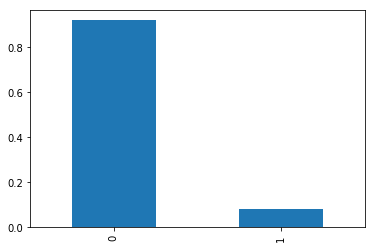

In [91]:
share_target = data_1['TARGET'].value_counts(normalize=True)
print(share_target)
share_target.plot.bar()

## Application Data Only

Analyze distribution of attributes differ between target group, using `application_train.csv` data only.

In [31]:
data_1 = data_appl_train

## Application with Bureau Data

Analyze distribution of attributes differ between target group, for those application that have bureaau data from combining `application_train.csv`and `data_bureau.csv`.

In [32]:
col_ID = 'SK_ID_CURR'

In [33]:
data_2 = data_appl_train.merge(data_bureau, left_on=col_ID, right_on=col_ID, how='inner')

In [94]:
target_mask = data_2[col_target] == 1

Convert column to categorical column.

In [35]:
convert_to_categorical(data_2)

Column TARGET casted to categorical
Column NAME_CONTRACT_TYPE casted to categorical
Column CODE_GENDER casted to categorical
Column FLAG_OWN_CAR casted to categorical
Column FLAG_OWN_REALTY casted to categorical
Column CNT_CHILDREN casted to categorical
Column NAME_TYPE_SUITE casted to categorical
Column NAME_INCOME_TYPE casted to categorical
Column NAME_EDUCATION_TYPE casted to categorical
Column NAME_FAMILY_STATUS casted to categorical
Column NAME_HOUSING_TYPE casted to categorical
Column FLAG_MOBIL casted to categorical
Column FLAG_EMP_PHONE casted to categorical
Column FLAG_WORK_PHONE casted to categorical
Column FLAG_CONT_MOBILE casted to categorical
Column FLAG_PHONE casted to categorical
Column FLAG_EMAIL casted to categorical
Column OCCUPATION_TYPE casted to categorical
Column CNT_FAM_MEMBERS casted to categorical
Column REGION_RATING_CLIENT casted to categorical
Column REGION_RATING_CLIENT_W_CITY casted to categorical
Column WEEKDAY_APPR_PROCESS_START casted to categorical
Col

In [95]:
cols_num = list(set(data_2.select_dtypes(include=[np.number]).columns) - set([col_ID]))
cols_cat = list(set(data_2.select_dtypes(exclude=[np.number]).columns) - set([col_target]))

Remove infinity values.

In [38]:
data_2 = data_2.replace([np.inf, -np.inf], np.nan)

### Numerical Columns

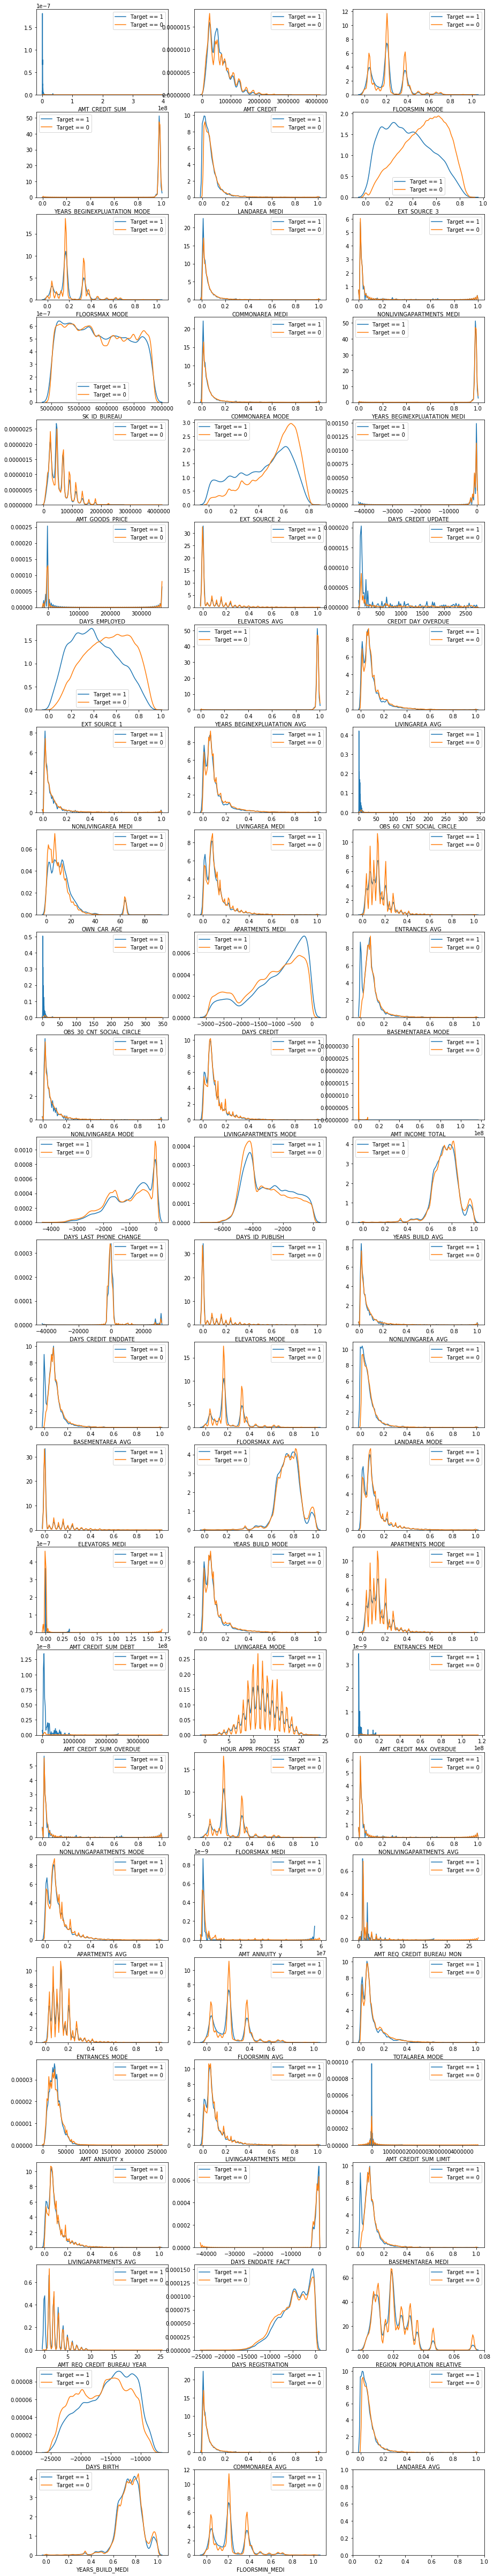

In [73]:
n = math.ceil(len(cols_num) / 3)
fig, ax = plt.subplots(n, 3, figsize=(15, 3.5*n))
for col, a in zip(cols_num, ax.reshape(-1)):
    sns.kdeplot(data_2[target_mask][col].dropna(), ax=a)
    sns.kdeplot(data_2[~target_mask][col].dropna(), ax=a)
    a.legend(["Target == 1", "Target == 0"])
    a.set_xlabel(col)

### Categorical Columns

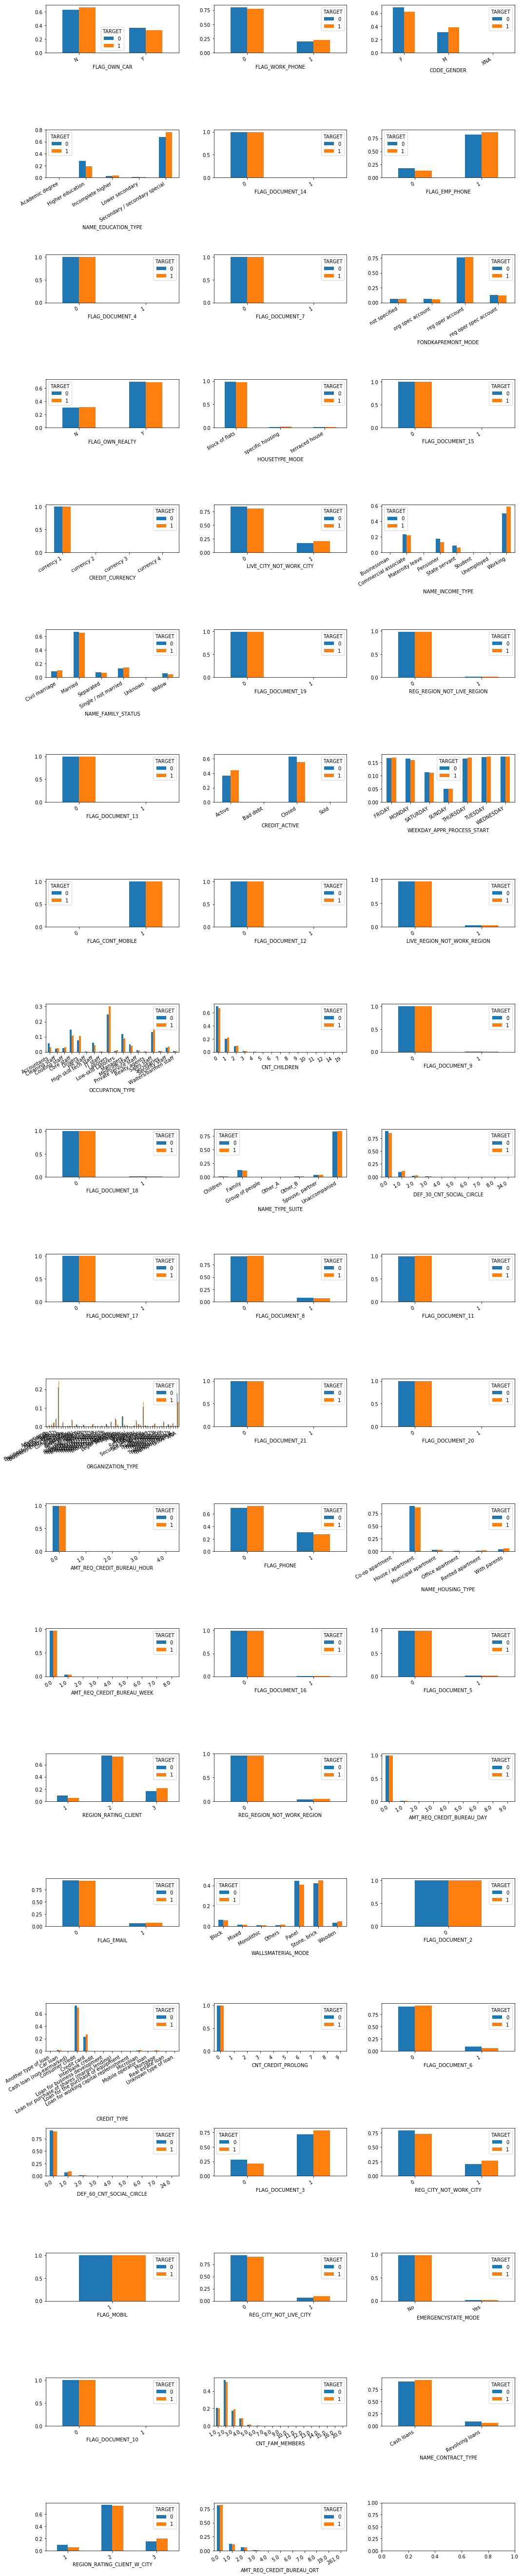

In [96]:
n = math.ceil(len(cols_cat) / 3)
fig, ax = plt.subplots(n, 3, figsize=(15, 3.5*n))
for col, a in zip(cols_cat, ax.reshape(-1)):
    data_2.groupby(col_target)[col].value_counts(normalize=True).unstack(0).plot.bar(ax=a)
    a.set_xticklabels(a.get_xticklabels(), rotation=30, ha='right')
plt.tight_layout()

## Application with Previous Application Data

Analyze distribution of attributes differ between target group, for those application that have bureaau data from combining `application_train.csv`and `previous_application.csv`.

In [61]:
col_ID = 'SK_ID_CURR'

In [62]:
data_3 = data_appl_train.merge(data_prev_appl, left_on=col_ID, right_on=col_ID, how='inner')

In [97]:
target_mask = data_3[col_target] == 1

Convert column to categorical column.

In [64]:
convert_to_categorical(data_3)

Column TARGET casted to categorical
Column NAME_CONTRACT_TYPE_x casted to categorical
Column CODE_GENDER casted to categorical
Column FLAG_OWN_CAR casted to categorical
Column FLAG_OWN_REALTY casted to categorical
Column CNT_CHILDREN casted to categorical
Column NAME_TYPE_SUITE_x casted to categorical
Column NAME_INCOME_TYPE casted to categorical
Column NAME_EDUCATION_TYPE casted to categorical
Column NAME_FAMILY_STATUS casted to categorical
Column NAME_HOUSING_TYPE casted to categorical
Column FLAG_MOBIL casted to categorical
Column FLAG_EMP_PHONE casted to categorical
Column FLAG_WORK_PHONE casted to categorical
Column FLAG_CONT_MOBILE casted to categorical
Column FLAG_PHONE casted to categorical
Column FLAG_EMAIL casted to categorical
Column OCCUPATION_TYPE casted to categorical
Column CNT_FAM_MEMBERS casted to categorical
Column REGION_RATING_CLIENT casted to categorical
Column REGION_RATING_CLIENT_W_CITY casted to categorical
Column WEEKDAY_APPR_PROCESS_START_x casted to categoric

In [98]:
cols_num = list(set(data_3.select_dtypes(include=[np.number]).columns) - set([col_ID]))
cols_cat = list(set(data_3.select_dtypes(exclude=[np.number]).columns) - set([col_target]))

Remove infinity values.

In [67]:
data_3 = data_3.replace([np.inf, -np.inf], np.nan)

### Numerical Columns

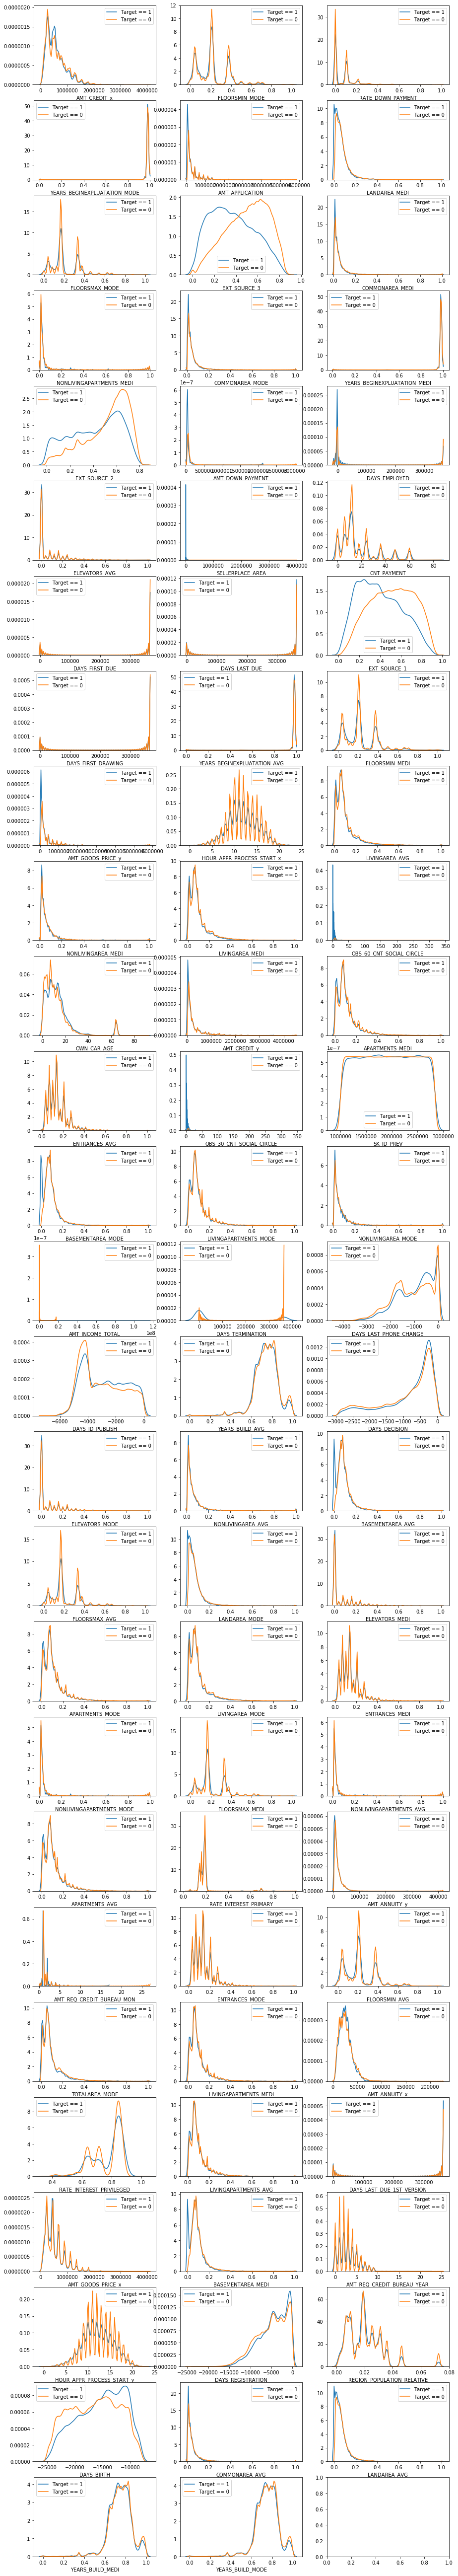

In [77]:
n = math.ceil(len(cols_num) / 3)
fig, ax = plt.subplots(n, 3, figsize=(15, 3.5*n))
for col, a in zip(cols_num, ax.reshape(-1)):
    sns.kdeplot(data_3[target_mask][col].dropna(), ax=a)
    sns.kdeplot(data_3[~target_mask][col].dropna(), ax=a)
    a.legend(["Target == 1", "Target == 0"])
    a.set_xlabel(col)

### Categorical Columns

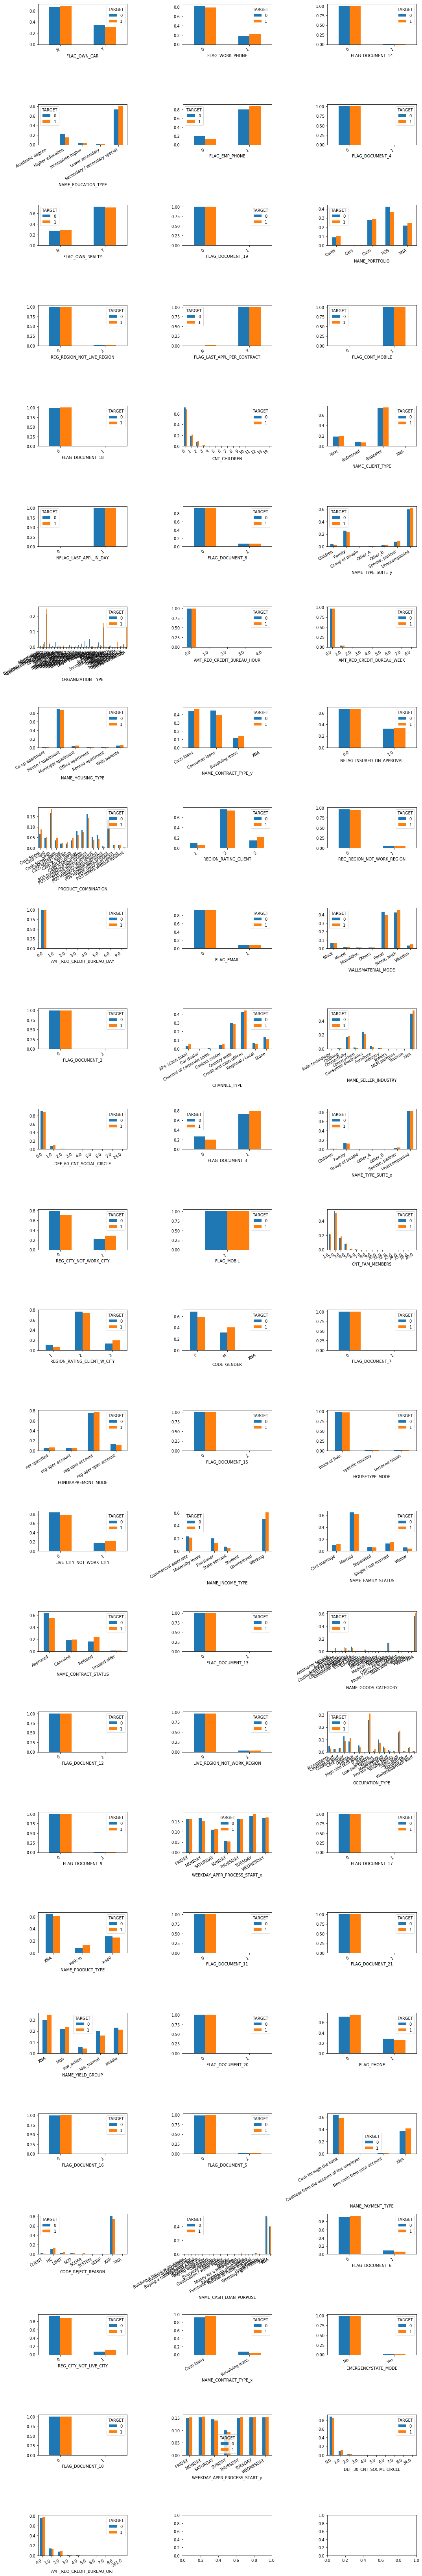

In [99]:
n = math.ceil(len(cols_cat) / 3)
fig, ax = plt.subplots(n, 3, figsize=(15, 3.5*n))
for col, a in zip(cols_cat, ax.reshape(-1)):
    data_3.groupby(col_target)[col].value_counts(normalize=True).unstack(0).plot.bar(ax=a)
    a.set_xticklabels(a.get_xticklabels(), rotation=30, ha='right')
plt.tight_layout()